In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [241]:
import keras
import sys
import h5py
import tensorflow as tf
import numpy as np
from numpy import linalg as LA
from collections import *
import matplotlib.pyplot as plt
from keras.callbacks import History 
import tensorflow.experimental.numpy as tnp
#from tensorflow_model_optimization.sparsity import keras as sparsity
%matplotlib inline

In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

def get_data(filepath):
    x,y = data_loader(filepath)
    x = data_preprocess(x)

    return x,y

def get_acc(model,x_test,y_test):
    clean_label_p = np.argmax(model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100
    print('Classification accuracy:', class_accu)

In [ ]:
#datapath
filepath_clean_test = '/content/drive/MyDrive/ML Cybersecurity Project/Dataset/clean_test_data.h5'
filepath_clean_val = '/content/drive/MyDrive/ML Cybersecurity Project/Dataset/clean_validation_data.h5'
filepath_sunglasses = '/content/drive/MyDrive/ML Cybersecurity Project/Dataset/sunglasses_poisoned_data.h5'
filepath_sunglasses_1 = '/content/drive/MyDrive/data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5'
filepath_lipstick = '/content/drive/MyDrive/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5'
filepath_eyebrows = '/content/drive/MyDrive/data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5'
filepath_anonymous_1 = '/content/drive/MyDrive/data/anonymous_1_poisoned_data.h5'
#modelpath
model_filename_sunglasses = '/content/drive/MyDrive/ML Cybersecurity Project/Model/sunglasses_bd_net.h5'
model_filename_anonymous_1 = '/content/drive/MyDrive/ML Cybersecurity Project/Model/anonymous_bd_net.h5'
model_filename_anonymous_2 = '/content/drive/MyDrive/ML Cybersecurity Project/Model/anonymous_2_bd_net.h5'
#weightpath
sunglasses_bd_weight = '/content/drive/MyDrive/ML Cybersecurity Project/Model/sunglasses_bd_weights.h5'
anonymous_bd_weight = '/content/drive/MyDrive/ML Cybersecurity Project/Model/anonymous_1_bd_weights.h5'
anonymous_2_bd_weight = '/content/drive/MyDrive/ML Cybersecurity Project/Model/anonymous_2_bd_weights.h5'
multitrigger_bd_weight = '/content/drive/MyDrive/ML Cybersecurity Project/Model/multi_trigger_multi_target_bd_weights.h5'
#get data
x_test,y_test = get_data(filepath_clean_test)
x_val,y_val = get_data(filepath_clean_val)
x_sunglasses,y_sunglasses = get_data(filepath_sunglasses)
x_anonymous_1,y_anonymous_1 = get_data(filepath_anonymous_1)
x_lipstick,y_lipstick = get_data(filepath_lipstick)
x_eyebrows,y_eyebrows = get_data(filepath_eyebrows)
x_sunglasses_1,y_sunglasses_1 = get_data(filepath_sunglasses_1)

In [ ]:
import keras
import keras.backend as K
from keras import initializers


def Net():
	# define input
	x = keras.Input(shape=(55, 47, 3), name='input')
	# feature extraction
	conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
	pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
	conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
	pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
	conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
	pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
	# first interpretation model
	flat_1 = keras.layers.Flatten()(pool_3)	
	fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)
	# second interpretation model
	conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
	flat_2 = keras.layers.Flatten()(conv_4)
	fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
	# merge interpretation
	merge = keras.layers.Add()([fc_1, fc_2])
	add_1 = keras.layers.Activation('relu')(merge)
	drop = keras.layers.Dropout(0.5)
	# output
	y_hat = keras.layers.Dense(1283, activation='softmax', name='output')(add_1)
	model = keras.Model(inputs=x, outputs=y_hat)
	# summarize layers
	#print(model.summary())
	# plot graph
	#plot_model(model, to_file='model_architecture.png')

	return model


K.clear_session()
model = Net()

In [975]:
model = Net()
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
___________________________________________________________________________________________

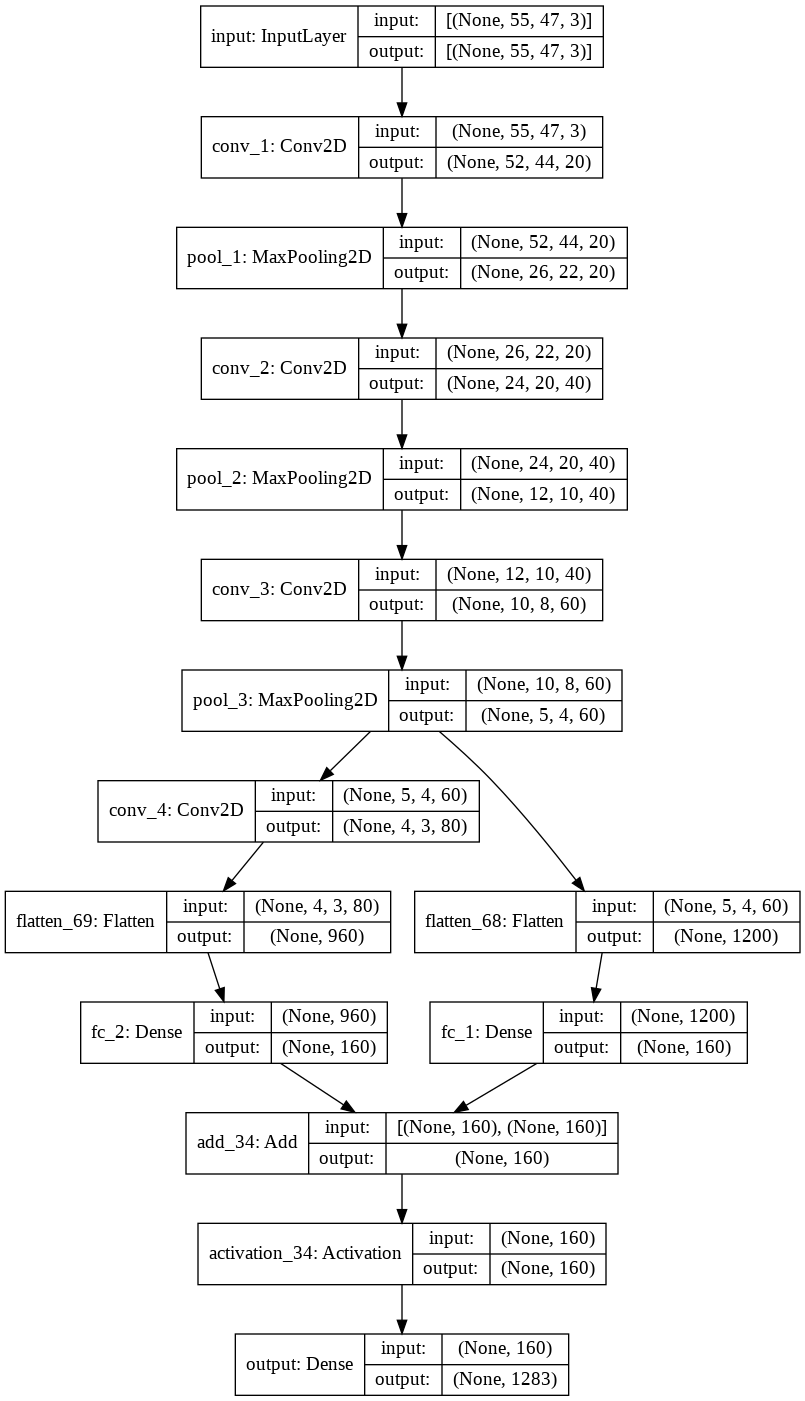

In [979]:
keras.utils.plot_model(model,show_shapes=True)

# Neuron pruning  
In pruning, we set the weights of the target neuron to zero. The weights consists of kernel weights and bias weights.  
In this project, we focus on conv3 layer and conv4 layer becasue both are the last convolution layer immediately before the flatten layer of first and second interpretation.  
We rank the activation levels of each neuron by computing the average on L1-norm of each neuron. The lowest activated neuron is pruned one by one until the accuracy on the clean test data drops. 

In [333]:
def  prune_conv_layer(f_weights, b_weights, channels,layer_name):
     """
         f_weights : filter weights with 4 dimensions, e.g. (2,2,60,80) ; filter size 2 x 2, 60 filters/channel, 80 channels in total
         b_weights : bias weights with dimension (80,)
         channels : a list of channels to be pruned
         layer_name : a name of a layer being pruned
     """
     #set weights of filters in channels = 0 
     filter_weights = np.copy(f_weights)
     for channel in channels:
         for j in range(filter_weights[:,:,:,channel].shape[-1]):
             for k,_ in enumerate(filter_weights[:,:,j,channel]):
                 filter_weights[k,:,j,channel] = 0
         #print(f'remove weights from {layer_name} layer, channel {channel}')
     #set bias weights = 0
     bias_weights = np.copy(b_weights)
     for channel in channels:
         bias_weights[channel] = 0
          
     return filter_weights, bias_weights

In [334]:
def get_pruned_model(model,pruned_layer,channels):
    """
       model : keras model with weights
       pruned_layers : a layer to be pruned, e.g. 'conv4'
       channels : a list of pruned channels     
    """
    # Copying a temporary sparse model from our original
    pruned_model = tf.keras.models.clone_model(model)
    pruned_model.set_weights(model.get_weights())
    # Getting weights from model
    weights = pruned_model.get_weights()
    
    if pruned_layer == 'conv4':
        f_weights, b_weights = prune_conv_layer(weights[6],weights[7],channels,pruned_layer)
        weights[6] = f_weights
        weights[7] = b_weights
        pruned_model.set_weights(weights)
    elif pruned_layer == 'conv3':
        f_weights, b_weights = prune_conv_layer(weights[4],weights[5],channels,pruned_layer)
        weights[4] = f_weights
        weights[5] = b_weights
        pruned_model.set_weights(weights)
    #elif pruned_layer == 'conv2':
    #    f_weights, b_weights = prune_conv_layer(weights[2],weights[3],channels,pruned_layer)
    #    weights[2] = f_weights
    #    weights[3] = b_weights
    #    pruned_model.set_weights(weights)
    else:
        raise NameError('Invalid layer name!!')
        
    return pruned_model

In [335]:
def get_dormant_neurons(model,clean_data,clean_label,layer_name):
    temp_model = keras.models.clone_model(model)
    temp_model.set_weights(model.get_weights())
    #create batch data for gpu
    BATCH_SIZE = 64
    train_dataset = tf.data.Dataset.from_tensor_slices(clean_data)
    x_batch = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    prune_set = None
    if layer_name == 'conv3':
        in_to_conv3 = [temp_model.layers[i].output for i in range(7)]
        extract_model = keras.Model(inputs=temp_model.input,outputs=in_to_conv3)

        avg_activation_conv3 = tf.zeros((5,4,60))

        for x in x_batch:
            layer_output_valid = extract_model(x)
            for activation in layer_output_valid[-1]:
                avg_activation_conv3 += activation

        avg_activation_conv3 /= len(clean_data)
        
        avg = defaultdict(float)
        for i in range(avg_activation_conv3.shape[-1]):
            avg[i] = tf.reduce_sum(avg_activation_conv3[:,:,i:i+1]).numpy()/20

        pruning_channels_low_to_high = []
        for k, _ in sorted(avg.items(), key=lambda item: item[1]):
            pruning_channels_low_to_high.append(k)

        base_acc = get_accuracy(temp_model,clean_data,clean_label)
        acc_val = []
        counter = 0
        conv3_pruning = None
        for i in range(60):
            pruned_model = get_pruned_model(temp_model,'conv3',pruning_channels_low_to_high[:i+1]) 
            a = get_accuracy(pruned_model,x_val,y_val)
            if a < base_acc:
                counter += 1
            else: 
                counter = 0
                acc_val.append(a)
            if counter == 3:
                conv3_pruning = pruning_channels_low_to_high[:len(acc_val)]
                break
    
        prune_set = conv3_pruning
    elif layer_name == 'conv4':
        in_to_conv4 = [temp_model.layers[i].output for i in range(8)]
        extract_model = keras.Model(inputs=temp_model.input,outputs=in_to_conv4)

        avg_activation_conv4 = tf.zeros((4,3,80))

        for x in x_batch:
            layer_output_valid = extract_model(x)
            for activation in layer_output_valid[-1]:
                avg_activation_conv4 += activation

        avg_activation_conv4 /= len(clean_data)
        
        avg = defaultdict(float)
        for i in range(avg_activation_conv4.shape[-1]):
            avg[i] = tf.reduce_sum(avg_activation_conv4[:,:,i:i+1]).numpy()/12

        pruning_channels_low_to_high = []
        for k, _ in sorted(avg.items(), key=lambda item: item[1]):
            pruning_channels_low_to_high.append(k)

        base_acc = get_accuracy(temp_model,clean_data,clean_label)
        acc_val = []
        counter = 0
        conv4_pruning = None
        for i in range(80):
            pruned_model = get_pruned_model(temp_model,'conv4',pruning_channels_low_to_high[:i+1]) 
            a = get_accuracy(pruned_model,x_val,y_val)
            if a < base_acc:
                counter += 1
            else: 
                counter = 0
                acc_val.append(a)
            if counter == 3:
                conv4_pruning = pruning_channels_low_to_high[:len(acc_val)]
                break
    
        prune_set = conv4_pruning
    else:
        raise NameError('Invalid layer name!!')

    return prune_set

# Fine-Pruning
* remove the dormant neurons from convolution layers
* use clean data from clean validaition set for fine-tuning
* stop when attack success rate of poisoned data is very low (close to 0%) and the accuracy on clean testset is still high (>= 90%)

In [982]:
def fine_tuning(model,clean_data,clean_label):
    base_model = keras.models.clone_model(model)
    base_model.set_weights(model.get_weights())

    #find dormant(decoy) neurons in conv3 layer
    conv3_pruning = get_dormant_neurons(base_model,clean_data,clean_label,'conv3')
    print(f'conv3 dormant neurons: {conv3_pruning}')
    base_model = get_pruned_model(base_model,'conv3',conv3_pruning)
    #find dormant(decoy) neurons in conv3 layer
    conv4_pruning = get_dormant_neurons(base_model,clean_data,clean_label,'conv4')
    print(f'conv4 dormant neurons: {conv4_pruning}')
    base_model = get_pruned_model(base_model,'conv4',conv4_pruning)

    base_model.trainable = True
    base_model.layers[1] = False
    base_model.layers[3] = False
    print('Start fine-tuning!!')
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    base_model.compile(optimizer=keras.optimizers.Adam(1e-5),loss=loss_fn,metrics=['accuracy'])
    base_model.fit(clean_data,clean_label,epochs=200,shuffle=True)
    print('finish!!')
    
    return base_model

# Repaired net  
Repaired net consists of 2 sub-models inside. First, the badnet which has high accuracy on both clean and poisoned data. Second, the fine-pruned net. In the last layer of repaired net, we use the lambda layer to compare the prediction from each sub-model. Because of high robustness of fine-pruning DNN, the poisoned data will be misclassified. Therfore, if the predictions from 2 sub-models are different, that means the input is poisoned. The difference accuracy on clean data of sub-models are different, so some of clean data misclassified by the repaired net. The chance of this situation depends on the difference of sub-model accuracy on clean data. However, the difference is not significant (around 6-7%) compared to the robustness that the repaired net gains from fine-pruning (99% reduction in the attack success rate).  
The output of this repaired net is a class predicted by the model like a detector. The repaired net will return 1283 for an poisoned image and 0-1282 for a clean image.

In [332]:
#some funcionality as the given function but we don't want to print anything out.
def get_accuracy(model,x_test,y_test):
    clean_label_p = np.argmax(model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100
    return class_accu

In [314]:
def repaired_Net():
    # define input
    x = keras.Input(shape=(55, 47, 3), name='input')
    # feature extraction
    conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
    pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
    conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
    pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
    #--
    conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3_base')(pool_2)
    pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3_base')(conv_3)
    # first interpretation model
    flat_1 = keras.layers.Flatten()(pool_3)	
    fc_1 = keras.layers.Dense(160, name='fc_1_base')(flat_1)
    # second interpretation model
    conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4_base')(pool_3)
    flat_2 = keras.layers.Flatten()(conv_4)
    fc_2 = keras.layers.Dense(160, name='fc_2_base')(flat_2)
    # merge interpretation
    merge_1 = keras.layers.Add()([fc_1, fc_2])
    add_1 = keras.layers.Activation('relu')(merge_1)
    drop = keras.layers.Dropout(0.5)
    # output
    y_hat_1 = keras.layers.Dense(1283, activation='softmax', name='output_1')(add_1)
    #--
    #this part use weight from fine-pruning model
    conv_3_fp = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3_fp')(pool_2)
    pool_3_fp = keras.layers.MaxPooling2D((2, 2), name='pool_3_fp')(conv_3_fp)
    # first interpretation model
    flat_3 = keras.layers.Flatten()(pool_3_fp)	
    fc_3 = keras.layers.Dense(160, name='fc_3')(flat_3)
    # second interpretation model
    conv_4_fp = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4_fp')(pool_3_fp)
    flat_4 = keras.layers.Flatten()(conv_4_fp)
    fc_4 = keras.layers.Dense(160, name='fc_4')(flat_4)
    # merge interpretation
    merge_2 = keras.layers.Add()([fc_3, fc_4])
    add_2 = keras.layers.Activation('relu')(merge_2)
    drop = keras.layers.Dropout(0.5)
    # output
    y_hat_2 = keras.layers.Dense(1283, activation='softmax', name='output_2')(add_2)

    #compare layer for class N+1
    def get_class(tensor_list):
        a = tf.math.argmax(tensor_list[0][0])
        b = tf.math.argmax(tensor_list[1][0])
        if tf.where([a == b]).shape[0] == 0:
            return tf.constant(1283)
        else: 
            return a
    lambda_layer = keras.layers.Lambda(get_class,name='Lambda')([y_hat_1,y_hat_2])
    model = keras.Model(inputs=x, outputs=lambda_layer)
    # summarize layers
    #print(model.summary())
    # plot graph
    #plot_model(model, to_file='model_architecture.png')

    return model

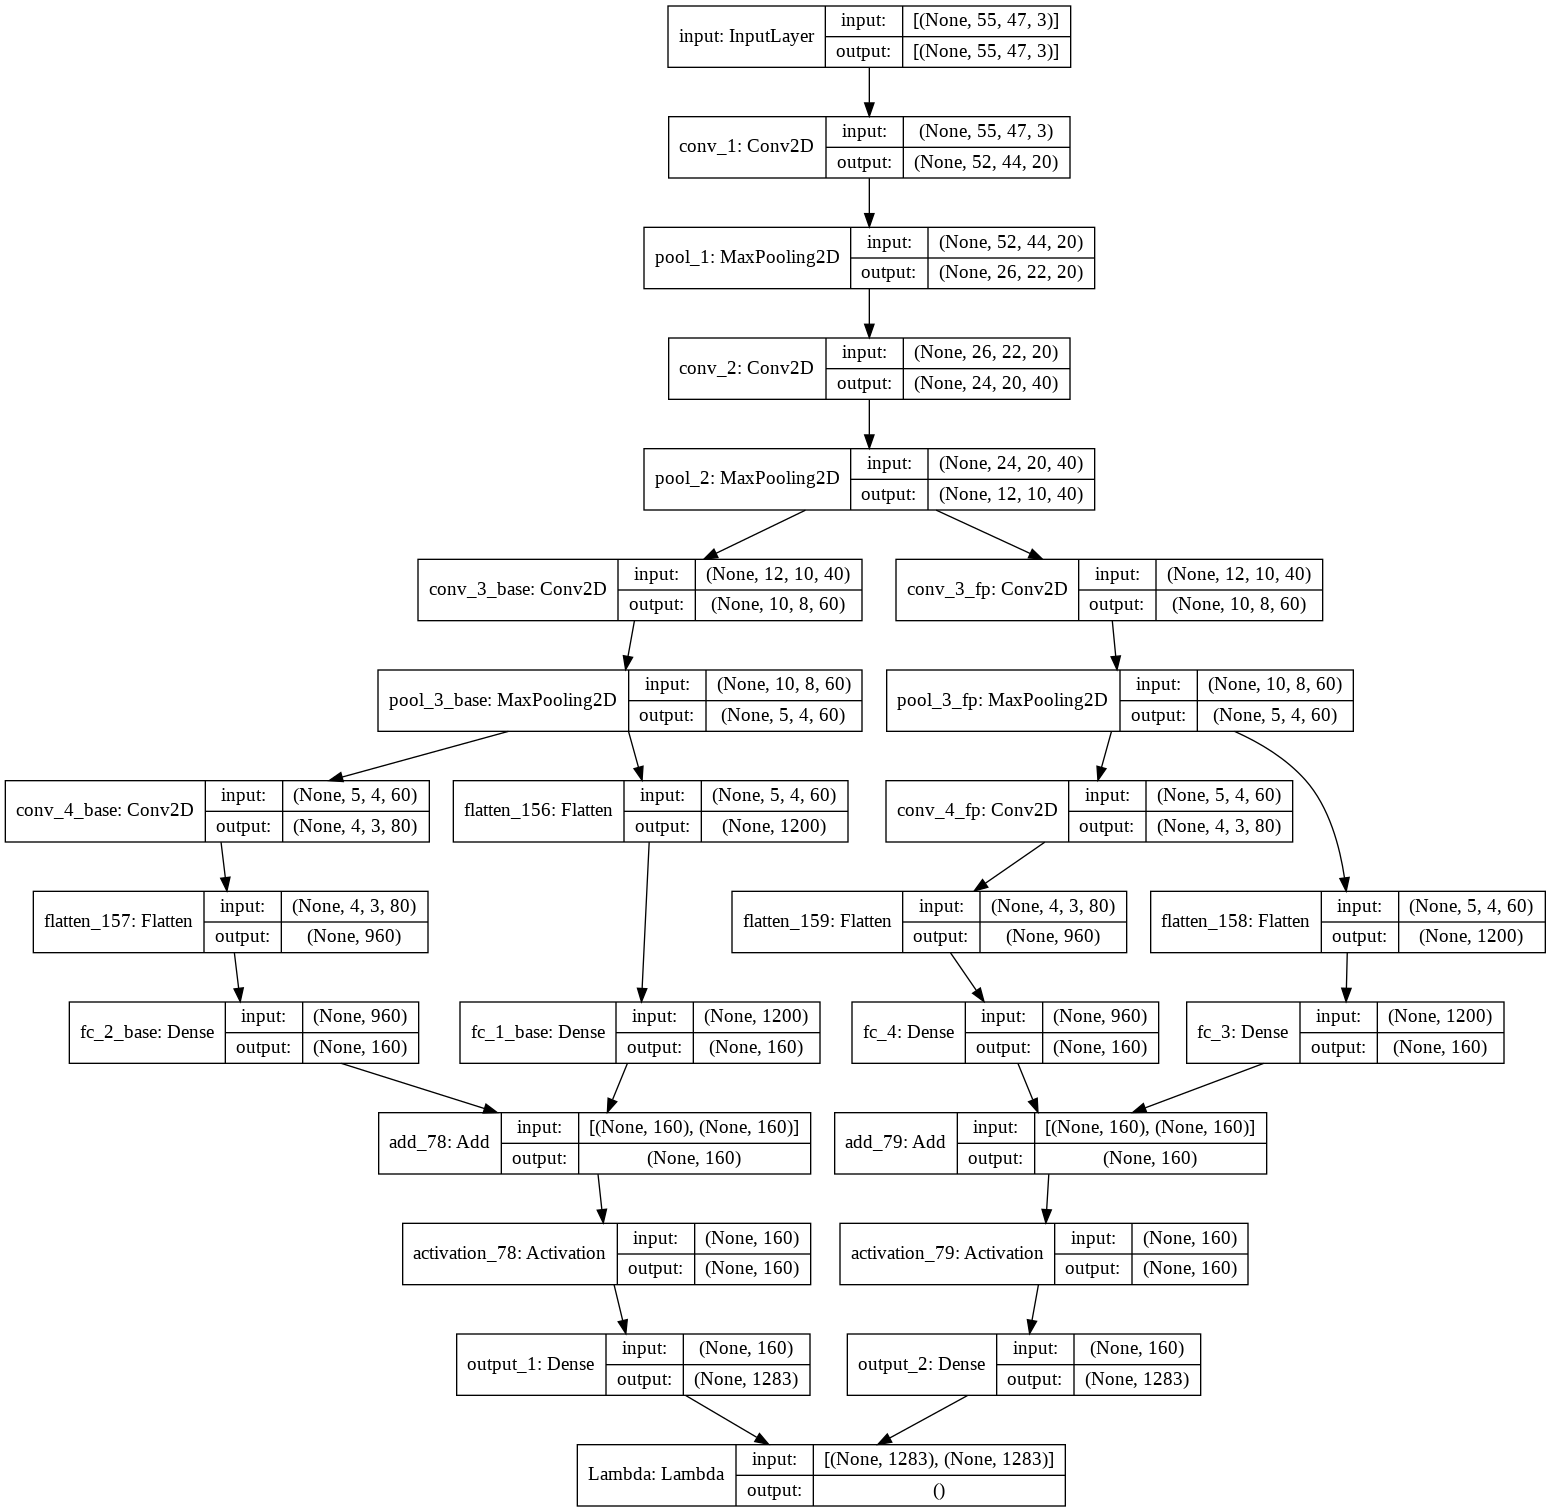

In [315]:
r_model = repaired_Net()
keras.utils.plot_model(r_model,show_shapes=True)

In [318]:
r_model.summary()

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
___________________________________________________________________________________________

In [981]:
def transfer_weight(repaired_model,base_model,fine_pruning_model):
    b_model = keras.models.clone_model(base_model)
    b_model.set_weights(base_model.get_weights())
    b_weights = b_model.get_weights()

    r_model = keras.models.clone_model(repaired_model)
    r_model.set_weights(repaired_model.get_weights())
    r_weights = r_model.get_weights()

    fp_model = keras.models.clone_model(fine_pruning_model)
    fp_model.set_weights(fine_pruning_model.get_weights())
    fp_weights = fp_model.get_weights()

    #input to conv2
    r_weights[0] = b_weights[0]
    r_weights[1] = b_weights[1]
    r_weights[2] = b_weights[2]
    r_weights[3] = b_weights[3]

    #conv3_1 to output_1
    r_weights[4] = b_weights[4]
    r_weights[5] = b_weights[5]
    r_weights[8] = b_weights[6]
    r_weights[9] = b_weights[7]
    r_weights[12] = b_weights[8]
    r_weights[13] = b_weights[9]
    r_weights[14] = b_weights[10]
    r_weights[15] = b_weights[11]
    r_weights[20] = b_weights[12]
    r_weights[21] = b_weights[13]

    #conv3_2 to output_2
    r_weights[6] = fp_weights[4]
    r_weights[7] = fp_weights[5]
    r_weights[10] = fp_weights[6]
    r_weights[11] = fp_weights[7]
    r_weights[16] = fp_weights[8]
    r_weights[17] = fp_weights[9]
    r_weights[18] = fp_weights[10]
    r_weights[19] = fp_weights[11]
    r_weights[22] = fp_weights[12]
    r_weights[23] = fp_weights[13]

    r_model.set_weights(r_weights)

    return r_model